# Machine Learning Pipeline - Production

Check the python kernel we are using, should be the local one, not the one in the virtual environment. <br>
NOTE: A proper virtual environment will be setup later on

In [26]:
import sys
print(sys.executable)

/usr/bin/python3


## Define Variables

Set up main variables that will be called later on, for readibility purposes

In [27]:
install_bool = True
path_to_datasets = "/home/ieo7429/Desktop/THESIS_GAB/outfiles/target_variables/ML_tables_regression_classification_BRCA_v2.RData"
mode = "regrout"

cols_to_drop = ["ampl_score","del_score","mean_log2FC","weighted_log2FC", "joint_probability", "bool_diff_acc", 
                "sign_mean_log2FC_1", "sign_mean_log2FC_2", "sign_mean_log2FC_3", 
                "weighted_coef_of_var_log2FC", "weighted_log2FC", "bin", "Type"]

if "ampl_score" in cols_to_drop and "del_score" in cols_to_drop:
    condition = "without_CNA"
else:
    condition = "with CNA"

n_jobs = 100
nthread = 100
n_iter_bsearch = 50
n_iter_rsearch = 50

split_random_state = 489574
classifier_seed = 3737
classifier_random_state = 39473209
hypertune_random_state_bsearch = 3847
hypertune_random_state_rsearch = 49574
kfold_random_state = 4909

outer_cv = 3
inner_cv = 2
plot_gain = False
plot_shap = True

X_train_filename = "MultiClassification_Output/mclassification_X_train_red"; X_test_filename = "MultiClassification_Output/mclassification_X_test_red"
y_train_filename = "MultiClassification_Output/mclassification_y_train_red"; y_test_filename = "MultiClassification_Output/mclassification_y_test_red"
bin_train_filename = "MultiClassification_Output/mclassification_bin_train_red"; bin_test_filename = "MultiClassification_Output/mclassification_bin_test_red"
model_filename = "MultiClassification_Output/mclassification_final_model"

## Install packages

Install all needed packages

In [28]:
from IPython.display import clear_output

if install_bool:
    ! pip install pickleshare
    ! pip install pandas
    ! pip install scikit-learn
    ! pip install seaborn
    ! pip install scipy
    ! pip install --upgrade pip setuptools wheel
    ! pip install rpy2
    ! pip install shap
    ! pip install "numpy<=2.1"
    %pip install -U ipywidgets

clear_output(wait = False)

## Import libraries

Import all packages

In [29]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import rpy2.robjects as ro
import xgboost as xgb
import shap
import warnings
import pickleshare
import pickle
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from skopt import BayesSearchCV
from sklearn.feature_selection import SelectFromModel

## Define Functions

### load_datasets_from_r
Reads "ML.Tables" .Rdata file and converts it to a nested dictionary.

In [30]:
def load_datasets_from_r(file_path):

    """ 
    The function uses rpy2 to load datasets from an RData file.
    In particular it expects a list of data.frames
    It returns a dictionary of pandas DataFrames.
    """
    
    pandas2ri.activate()

    ro.r['load'](file_path) # load the .RData

    env = ro.globalenv # set the environment

    r_list = env[list(env.keys())[0]] # take the list object

    list_names = ro.r['names'](r_list) # take the names
    list_names = [str(name) for name in list_names]

    df_dict = {} # initialize outer dictionary
    with (ro.default_converter + ro.pandas2ri.converter).context(): # start the conversion
    # the conversion transforms a list of lists of lists of data.frames 
    # to a list of dictionaries of dictionaries of dictionaries of DataFrame
        i = 0
        for outer_dict in r_list:
            df_dict[list_names[i]] = outer_dict
            i += 1
            
    return(df_dict)

### gini_coefficient

Function to compute the gini coefficient (2 * AUC - 1)

In [31]:
def gini_coefficient_score(y_true, y_pred_prob, **kwargs):
    y_score = y_pred_prob
    auc_score = sk.metrics.roc_auc_score(y_true, y_score, multi_class='ovr')
    gini_coef = 2 * auc_score - 1
    return gini_coef

In [32]:
gini_coefficient = sk.metrics.make_scorer(gini_coefficient_score, response_method = "predict_proba", greater_is_better= True)

### feature_selector
his function performs Incremental Feature Selection (IFS) to produce a reduced model <br> with best gini coefficient (2 * AUC - 1) performance with cross validation.
Mean absolute SHAP values are used to select features

In [33]:
def feature_selector_shap(feature_names, feature_importances, model, 
                          X_train, X_test, y_train, inner_cv,
                          plot = True, verbose = True):

    """
    The function takes as input feature names, feature importances, 
    a XGBoost Classifier object, the training and test dataset
    and returns the reduced training and test datasets.
    - plot parameter regulates whether or not to plot the Gini Coefficient vs number of feature plot
    - verbose parameter regulates whether or not to produce a text output
    """

    thresholds = np.sort(feature_importances) # sort the feature importances
    num_features_list = [] # initialize list
    gini_coef_list = [] # initialize list
    
    for threshold in thresholds: # iterate over thresholds
        
        vars_to_keep = np.where(feature_importances >= threshold)[0]
        X_train_selected = X_train.iloc[:,vars_to_keep]

        gini_coef_scores = sk.model_selection.cross_val_score(estimator = model, 
                                                              X = X_train_selected, y = y_train, 
                                                              scoring = gini_coefficient, cv = inner_cv)
        mean_gini_coef_score = np.mean(gini_coef_scores)
        
        num_features_list.append(X_train_selected.shape[1]) # append
        gini_coef_list.append(mean_gini_coef_score) # append

        if verbose:
            print(f'> threshold={threshold}, features={X_train_selected.shape[1]}, gini coefficient={mean_gini_coef_score}')
        
        if len(vars_to_keep) == 1:
            break

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(num_features_list, gini_coef_list, marker='o')
        plt.xlabel('Number of Selected Features')
        plt.ylabel('cross validated mean Ginny coefficient')
        plt.title('Gini coefficient vs. Number of Selected Features')
        plt.grid(True)
        plt.show()

    optimal_threshold_index = np.argmax(gini_coef_list)
    optimal_num_features = num_features_list[optimal_threshold_index]
    
    if (optimal_threshold_index) == 0:
        optimal_threshold = 0
    else:   
        optimal_threshold = thresholds[optimal_threshold_index - 1]

    if verbose:
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        print(f"Number of Selected Features: {optimal_num_features}")
        print(f"Gini coef at Optimal Threshold: {gini_coef_list[optimal_threshold_index]:.4f}")
        print("\n")
        
    n = 5
    selected_features = feature_names[np.where(feature_importances > optimal_threshold)]
    selected_features = [str(name) for name in selected_features]
    discarded_features = [str(name) for name in feature_names if str(name) not in selected_features]

    if verbose:
        print("Selected features are: \n")
        for i in range(0,len(selected_features), n):
            print("  ".join(selected_features[i:i+n]))
        print("\n")
        print("Discarded features are: \n")
        for i in range(0,len(discarded_features), n):
            print("  ".join(discarded_features[i:i+n]))

    X_train_reduced = X_train[selected_features]
    X_test_reduced = X_test[selected_features]
    
    return(X_train_reduced, X_test_reduced, selected_features)    

### Nested CV la vendetta

In [34]:
def nested_CV_revenge(outer_cv, inner_cv,
                      X_train, y_train, 
                      model, search_space, 
                      n_jobs, n_iter_bsearch, verbose):
    
    """
    The function performs nested cross validation to estimate model's error rate
    It take the cv number, the training dataset, the target variable, the model or a BayesSearchCV
    and a search space to perform hyperparameter tuning
    """
    
    kf = sk.model_selection.KFold(n_splits = outer_cv, 
                                  shuffle=True, 
                                  random_state = kfold_random_state)
    

    hyperparam_list = []
    selected_features_list = []
    accuracy_array = np.zeros(outer_cv)
    f1_array = np.zeros(outer_cv)
    precision_array = np.zeros(outer_cv)
    recall_array = np.zeros(outer_cv)
    roc_auc_array = np.zeros(outer_cv)
    predictions_array = np.zeros(len(X_train))
    probas_array = np.zeros((len(X_train),len(np.unique(y_train))))
    
    i = 0
    for train_index, val_index in kf.split(X_train):

        if verbose:
            print(f"Fold #{i + 1}")
            
        if verbose:
            print("STEP 1 (Splitting)")
            
        X_train_cv, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_cv, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        if verbose:
            print("STEP 2 (Tuning)")

        if verbose:
            print("STEP 2.1 (HyperParameter Tuning Part 1)")
        
        opti = BayesSearchCV(
            estimator = model,
            search_spaces = search_space,
            n_iter = n_iter_bsearch,
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True,
            n_jobs = n_jobs,
            verbose = 0
        )
        
        opti.fit(X_train_cv, y_train_cv)
        best_model = opti.best_estimator_

        if verbose:
            print("STEP 2.2 (SHAP)")
        
        explainer = shap.TreeExplainer(best_model)

        feature_names = best_model.feature_names_in_
        feature_importances_shap = np.mean(np.mean(np.abs(explainer.shap_values(X_train_cv)), axis = 0), axis = 1)
    
        if verbose:
            print("STEP 2.3 (Feature selection)")
        
        X_train_cv_reduced, X_val_cv_reduced, selected_features = feature_selector_shap(feature_names, feature_importances_shap, 
                                                                                        best_model, 
                                                                                        X_train_cv, X_val, y_train_cv,
                                                                                        inner_cv,
                                                                                        plot = False, verbose = False)

        if verbose:
            print("STEP 2.4 (HyperParameter Tuning Part 2)")
        
        opti_fs = BayesSearchCV(
            estimator = best_model, 
            search_spaces = search_space, 
            n_iter = n_iter_bsearch, 
            cv = inner_cv,
            random_state = hypertune_random_state_bsearch,
            refit = True, 
            n_jobs = n_jobs,
            verbose = 0
        )
        
        opti_fs.fit(X_train_cv_reduced, y_train_cv)
        best_model_fs = opti_fs.best_estimator_
        best_params_fs = opti_fs.best_params_
        
        if verbose:
            print("STEP 3 (Prediction)")
        
        cv_predictions = best_model_fs.predict(X_val_cv_reduced)
        cv_pred_probas = best_model_fs.predict_proba(X_val_cv_reduced)
        
        cv_accuracy = sk.metrics.accuracy_score(y_val, cv_predictions)
        cv_f1 = sk.metrics.f1_score(y_val, cv_predictions, average = "macro")
        cv_precision = sk.metrics.precision_score(y_val, cv_predictions, average = "macro")
        cv_recall = sk.metrics.recall_score(y_val, cv_predictions, average = "macro")
        cv_roc_auc = sk.metrics.roc_auc_score(y_val, cv_pred_probas, multi_class='ovr', average = "macro")
        
        hyperparam_list.append(best_params_fs)
        selected_features_list.append(selected_features)
        accuracy_array[i] = cv_accuracy 
        f1_array[i] = cv_f1
        precision_array[i] = cv_precision
        recall_array[i] = cv_recall
        roc_auc_array[i] = cv_roc_auc
        predictions_array[val_index] = cv_predictions
        probas_array[val_index] = cv_pred_probas
        
        i += 1

    return(hyperparam_list, selected_features_list, 
           accuracy_array, f1_array, precision_array, 
           recall_array, roc_auc_array, predictions_array, probas_array)

## Load Data

In [35]:
output_dict = load_datasets_from_r(path_to_datasets)

In [36]:
working_df = output_dict[mode]

In [37]:
significant_dir_1 = np.where(
    (working_df.bool_diff_acc == 1) & (working_df.sign_mean_log2FC_1 == 1), 2,
    np.where(
        (working_df.bool_diff_acc == 1) & (working_df.sign_mean_log2FC_1 == -1), 0, 1
    )
)

In [38]:
working_df["significant_dir_1"] = significant_dir_1

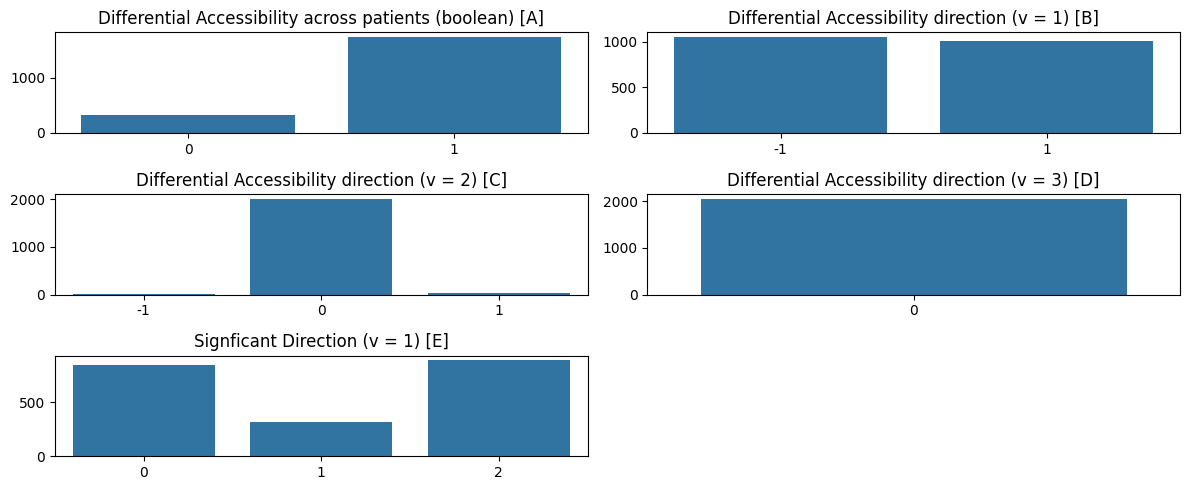

In [39]:
fig, axes = plt.subplots(3, 2, figsize=(12, 5))

A = axes[0,0]
B = axes[0,1]
C = axes[1,0]
D = axes[1,1]
E = axes[2,0]
F = axes[2,1]

sns.barplot(working_df.bool_diff_acc.value_counts(), ax = A)
sns.barplot(working_df.sign_mean_log2FC_1.value_counts(), ax = B)
sns.barplot(working_df.sign_mean_log2FC_2.value_counts(), ax = C)
sns.barplot(working_df.sign_mean_log2FC_3.value_counts(), ax = D)
sns.barplot(working_df.significant_dir_1.value_counts(), ax = E)


A.set_title("Differential Accessibility across patients (boolean) [A]")
B.set_title("Differential Accessibility direction (v = 1) [B]")
C.set_title("Differential Accessibility direction (v = 2) [C]")
D.set_title("Differential Accessibility direction (v = 3) [D]")
E.set_title("Signficant Direction (v = 1) [E]")

A.set_xlabel(""); A.set_ylabel("")
B.set_xlabel(""); B.set_ylabel("")
C.set_xlabel(""); C.set_ylabel("")
D.set_xlabel(""); D.set_ylabel("")
E.set_xlabel(""); E.set_ylabel("")

F.axis('off')

plt.tight_layout()

## Prepare Data

In [40]:
bin_ids = working_df[["bin"]]

In [41]:
working_df = working_df.drop(cols_to_drop, axis= 1)

In [42]:
working_df

,mean.GC.content,total_n_partners.trans,total_n_PPIs.trans_IntINSIDER,total_n_ohnologs.mmpaper_trans,total_n_paralogs_trans,dist.to.closest.FGS,Length_Counts.E1,Length_Counts.E10,Length_Counts.E11,Length_Counts.E12,...,distance.to.telomere,Ess.distance_pancancer,ESSscore_pancancer,HAPLOscore_pancancer,Density.complex.proteins,Density.Ohnologs,Chromosome_Length,Centromere_Length,Centromere_Type,significant_dir_1
1,50.325833,2.0,52.0,10.0,35.0,61789940.0,5400.0,22800.0,9400.0,41200.0,...,6791450.0,1.0,0.000000,0.416667,0.083333,0.500000,249250621,2906265,0,0
2,36.060000,0.0,12.0,1.0,2.0,26299595.0,1000.0,1400.0,0.0,500.0,...,96881990.0,1.0,0.000000,0.000000,0.000000,1.000000,249250621,2906265,0,1
3,38.824545,4.0,54.0,2.0,8.0,27300601.0,3600.0,3500.0,0.0,5300.0,...,97882996.0,0.0,0.090909,0.090909,0.090909,0.181818,249250621,2906265,0,0
4,39.422000,12.0,650.0,7.0,12.0,28301607.0,1900.0,0.0,600.0,1600.0,...,98884002.0,1.0,0.000000,0.400000,0.400000,0.200000,249250621,2906265,0,1
5,35.120000,0.0,6.0,6.0,4.0,29302613.0,0.0,0.0,0.0,0.0,...,99885008.0,1.0,0.000000,0.000000,0.000000,1.000000,249250621,2906265,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,41.840000,5.0,34.0,1.0,2.0,NaN,2000.0,3900.0,6700.0,2400.0,...,46796529.0,0.0,0.500000,0.500000,0.250000,0.250000,141213431,2128923,1,1
2050,45.479091,15.0,20.0,4.0,32.0,NaN,2000.0,16800.0,8700.0,10800.0,...,45795016.0,1.0,0.000000,0.272727,0.272727,0.272727,141213431,2128923,1,0
2051,48.625000,0.0,20.0,16.0,15.0,NaN,4600.0,13300.0,2000.0,24100.0,...,44793503.0,2.0,0.000000,0.666667,0.000000,0.500000,141213431,2128923,1,2
2052,45.106667,16.0,83.0,NaN,0.0,NaN,1500.0,36900.0,5900.0,8000.0,...,43791990.0,3.0,0.000000,0.000000,0.333333,0.000000,141213431,2128923,1,2


In [43]:
X = working_df.iloc[:, 0:-1]
y = working_df.iloc[:, -1]

In [44]:
if "significant_dir_1" in X.columns:
    raise Exception("Target Variable in the training set!")

In [45]:
X.columns

Index(['mean.GC.content', 'total_n_partners.trans',
       'total_n_PPIs.trans_IntINSIDER', 'total_n_ohnologs.mmpaper_trans',
       'total_n_paralogs_trans', 'dist.to.closest.FGS', 'Length_Counts.E1',
       'Length_Counts.E10', 'Length_Counts.E11', 'Length_Counts.E12',
       'Length_Counts.E13', 'Length_Counts.E14', 'Length_Counts.E15',
       'Length_Counts.E16', 'Length_Counts.E17', 'Length_Counts.E18',
       'Length_Counts.E19', 'Length_Counts.E2', 'Length_Counts.E20',
       'Length_Counts.E21', 'Length_Counts.E22', 'Length_Counts.E23',
       'Length_Counts.E24', 'Length_Counts.E25', 'Length_Counts.E3',
       'Length_Counts.E4', 'Length_Counts.E5', 'Length_Counts.E6',
       'Length_Counts.E7', 'Length_Counts.E8', 'Length_Counts.E9',
       'all.int.trans_IntINSIDER', 'genes.bin', 'partners.trans', 'density.OG',
       'density.TSG', 'dist.to.closest.OG', 'dist.to.closest.TSG',
       'mutations_norm', 'distance.to.centromere', 'distance.to.telomere',
       'Ess.distance_pan

In [46]:
X_train, X_test, y_train, y_test, bin_train, bin_test = sk.model_selection.train_test_split(X, y, bin_ids, test_size=0.3, random_state=split_random_state)

## Prepare the Classifier and the Search Space

In [47]:
classifier = xgb.XGBClassifier(n_jobs = n_jobs, nthread = nthread, seed = classifier_seed, random_state = classifier_random_state)

search_space_bayes = {  
    'learning_rate': (0.001, 1.0, 'log-uniform'),  
    'n_estimators': (50, 500),  
    'max_depth': (3, 15),  
    'min_child_weight': (1, 10),  
    'gamma': (1e-9, 5.0, 'log-uniform'),  
    'subsample': (0.5, 1.0, 'uniform'),  
    'colsample_bytree': (0.5, 1.0, 'uniform'),  
    'colsample_bylevel': (0.5, 1.0, 'uniform'),  
    'reg_alpha': (1e-9, 10.0, 'log-uniform'),  
    'reg_lambda': (1e-9, 10.0, 'log-uniform'),  
    'max_delta_step': (0, 10),  
    'objective': ['multi:softmax'],  
    'booster': ['gbtree', 'dart'],  
    'eval_metric': ['mlogloss', 'error', 'auc']  
}  

### NESTED CV PIPELINE

In [48]:
results = nested_CV_revenge(
    outer_cv, inner_cv,
    X_train=X_train,
    y_train=y_train,
    model=classifier,
    search_space=search_space_bayes,
    n_jobs= n_jobs, n_iter_bsearch = n_iter_bsearch,
    verbose=True
)

(
    hyperparam_list,
    selected_features_list,
    accuracy_array,
    f1_array,
    precision_array,
    recall_array,
    roc_auc_array,
    predictions_array,
    probas_array
) = results


Fold #1
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Prediction)
Fold #2
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Prediction)
Fold #3
STEP 1 (Splitting)
STEP 2 (Tuning)
STEP 2.1 (HyperParameter Tuning Part 1)
STEP 2.2 (SHAP)
STEP 2.3 (Feature selection)
STEP 2.4 (HyperParameter Tuning Part 2)
STEP 3 (Prediction)


In [49]:
print(f"The cross-validated accuracy (cv = {outer_cv}) is: {np.mean(accuracy_array)}")
print(f"The cross-validated f1 (cv = {outer_cv}) is: {np.mean(f1_array)}")
print(f"The cross-validated precision (cv = {outer_cv}) is: {np.mean(precision_array)}")
print(f"The cross-validated recall (cv = {outer_cv}) is: {np.mean(recall_array)}")
print(f"The cross-validated AUC (cv = {outer_cv}) is: {np.mean(roc_auc_array)}")

The cross-validated accuracy (cv = 3) is: 0.639526791927627
The cross-validated f1 (cv = 3) is: 0.5128426561137224
The cross-validated precision (cv = 3) is: 0.5425740075968996
The cross-validated recall (cv = 3) is: 0.5263704216382932
The cross-validated AUC (cv = 3) is: 0.7542632017691625


In [50]:
selected_features_in_at_least_one_cv = set([elem for inner_list in selected_features_list for elem in inner_list])

In [51]:
search_space_grid = {}

for dictionary in hyperparam_list:
    for k,v in dictionary.items():
        if k in search_space_grid:
            search_space_grid[k].update([v])
        else:
            search_space_grid[k] = set([v])

search_space_grid = {k : list(v) for k,v in search_space_grid.items()}

## Full Dataset Hyperparameter Tuning

In [52]:
opti = sk.model_selection.RandomizedSearchCV(estimator = classifier, 
                                             param_distributions = search_space_grid, 
                                             cv = inner_cv, 
                                             n_jobs = n_jobs,
                                             n_iter = n_iter_rsearch,
                                             random_state = hypertune_random_state_rsearch, 
                                             verbose = 3, refit = True)
opti.fit(X_train, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                        'max_delta_step': [1, 5, 7],
                                        'max_depth': [12, 14],
                                        'min_child_weight': [1],
                                        'n_estimators': [337, 227, 279],
                                        'objective': ['multi:softmax'],
                                        'reg_alpha': [1e-09,
                                                      5.216359255584036e-09,
                                                      1.6645638296230612e-09],
                                        'reg_lambda': [3.843136744976635e-06,
                                                       3.4538485585656455,
                                                       0.01021924868151315],
                                        'subsample': [0.5027532786348988,
                                                      0.8900303419147679,
                                                      0.6989591280403746]},
                   random_state=49574, verbose=3)

In [53]:
model = opti.best_estimator_

## Feature Importance Analysis

Let's look at both XGBoost native feature importance and at mean absolute SHAP values as metric of feature importance

In [54]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)
shap_values_numpy = explainer.shap_values(X_train)

regrout / without_CNA


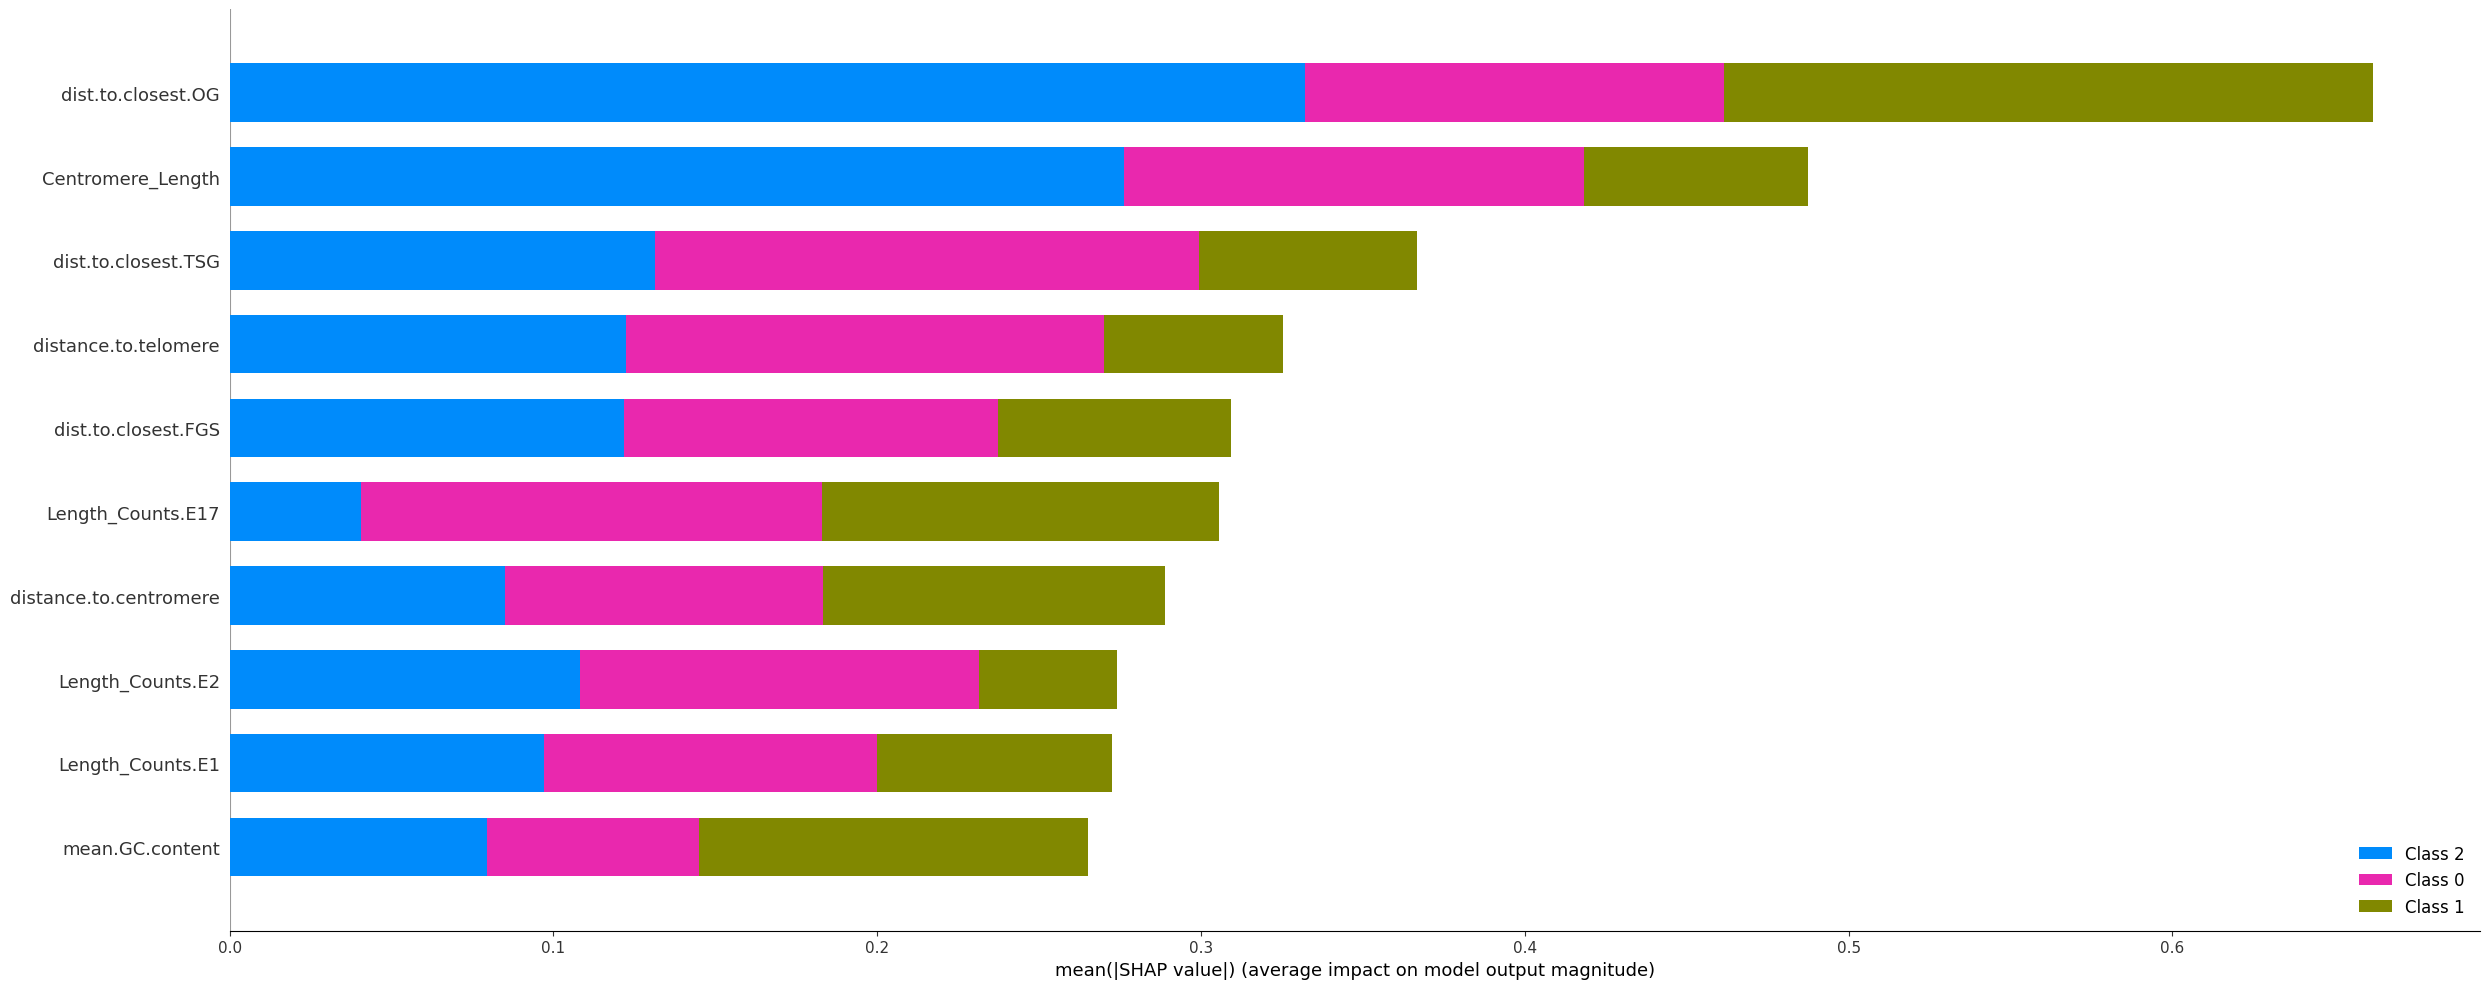

In [55]:
if plot_shap:
    print(" / ".join([mode, condition]))
    plt.figure(figsize = (100,25))
    summary_plot = shap.summary_plot(shap_values, X_train, 
                                     plot_type='bar', max_display=10, plot_size= (25,10))
    plt.show()

## Feature Selection

Let's perform Feature Selection using mean absolute SHAP values

> threshold=0.00030465659801848233, features=49, gini coefficient=0.49403762398604023
> threshold=0.0009461207664571702, features=48, gini coefficient=0.4872718681351995
> threshold=0.014049273915588856, features=47, gini coefficient=0.4913310058064537
> threshold=0.020592449232935905, features=46, gini coefficient=0.4910198125170935
> threshold=0.02309444546699524, features=45, gini coefficient=0.49195472368804527
> threshold=0.02462625503540039, features=44, gini coefficient=0.48524405692703254
> threshold=0.026206636801362038, features=43, gini coefficient=0.4900235760012783
> threshold=0.02798417955636978, features=42, gini coefficient=0.4918180785282602
> threshold=0.028389310464262962, features=41, gini coefficient=0.4883626560844625
> threshold=0.030036846175789833, features=40, gini coefficient=0.49338683513555004
> threshold=0.03040328621864319, features=39, gini coefficient=0.4930413598854768
[CV 2/2] END booster=gbtree, colsample_bylevel=0.6492623090630015, colsample_bytree=

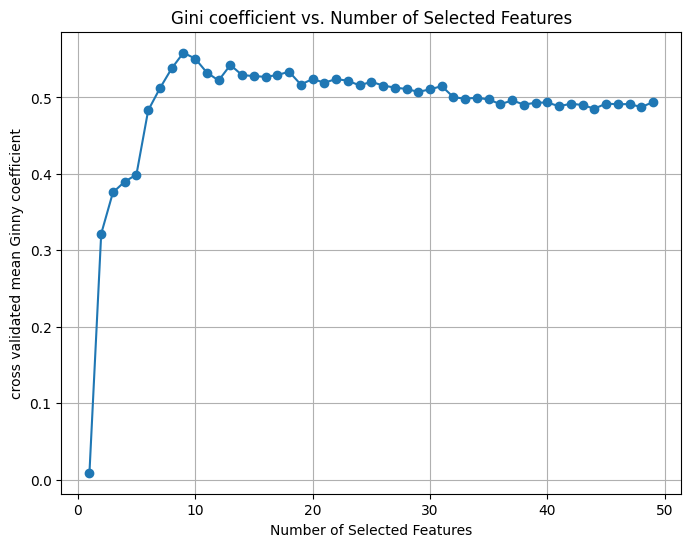

Optimal Threshold: 0.0884
Number of Selected Features: 9
Gini coef at Optimal Threshold: 0.5584


Selected features are: 

dist.to.closest.FGS  Length_Counts.E1  Length_Counts.E17  Length_Counts.E2  dist.to.closest.OG
dist.to.closest.TSG  distance.to.centromere  distance.to.telomere  Centromere_Length


Discarded features are: 

mean.GC.content  total_n_partners.trans  total_n_PPIs.trans_IntINSIDER  total_n_ohnologs.mmpaper_trans  total_n_paralogs_trans
Length_Counts.E10  Length_Counts.E11  Length_Counts.E12  Length_Counts.E13  Length_Counts.E14
Length_Counts.E15  Length_Counts.E16  Length_Counts.E18  Length_Counts.E19  Length_Counts.E20
Length_Counts.E21  Length_Counts.E22  Length_Counts.E23  Length_Counts.E24  Length_Counts.E25
Length_Counts.E3  Length_Counts.E4  Length_Counts.E5  Length_Counts.E6  Length_Counts.E7
Length_Counts.E8  Length_Counts.E9  all.int.trans_IntINSIDER  genes.bin  partners.trans
density.OG  density.TSG  mutations_norm  Ess.distance_pancancer  ESSscore_pancancer

In [56]:
feature_names = model.feature_names_in_
feature_importances_shap = np.mean(np.mean(np.abs(explainer.shap_values(X_train)), axis = 0),axis = 1)

X_train_reduced, X_test_reduced, selected_features = feature_selector_shap(feature_names, feature_importances_shap, 
                                                                            model, X_train, X_test, y_train, 
                                                                            inner_cv = inner_cv,
                                                                            plot = True, verbose = True)

In [57]:
features_to_discard = [feature for feature in selected_features if feature not in selected_features_in_at_least_one_cv]

In [58]:
print(f"Dropping columns never selected during Nested Cross Validation: {features_to_discard}")

Dropping columns never selected during Nested Cross Validation: []


In [59]:
X_train_reduced = X_train_reduced.drop(features_to_discard, axis = 1)
X_test_reduced = X_test_reduced.drop(features_to_discard, axis = 1)

In [60]:
opti_fs = sk.model_selection.RandomizedSearchCV(estimator = model, 
                                                param_distributions = search_space_grid, 
                                                cv = inner_cv, 
                                                n_jobs = n_jobs,
                                                n_iter = n_iter_rsearch,
                                                random_state = hypertune_random_state_rsearch, 
                                                verbose = 3, refit = True)
opti_fs.fit(X_train_reduced, y_train)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           callbacks=None,
                                           colsample_bylevel=0.6492623090630015,
                                           colsample_bynode=None,
                                           colsample_bytree=1.0, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None,
                                           feature_weights=None,
                                           gamma=4.9051344654427e-07,
                                           grow_policy=None,
                                           importanc...
                                        'max_delta_step': [1, 5, 7],
                                        'max_depth': [12, 14],
                                        'min_child_weight': [1],
                                        'n_estimators': [337, 227, 279],
                                        'objective': ['multi:softmax'],
                                        'reg_alpha': [1e-09,
                                                      5.216359255584036e-09,
                                                      1.6645638296230612e-09],
                                        'reg_lambda': [3.843136744976635e-06,
                                                       3.4538485585656455,
                                                       0.01021924868151315],
                                        'subsample': [0.5027532786348988,
                                                      0.8900303419147679,
                                                      0.6989591280403746]},
                   random_state=49574, verbose=3)

In [61]:
model_fs = opti_fs.best_estimator_

In [62]:
best_params_fs = opti_fs.best_params_

In [63]:
for k,v in best_params_fs.items():
    print(f"{k}: {v}")

subsample: 0.5027532786348988
reg_lambda: 3.843136744976635e-06
reg_alpha: 1.6645638296230612e-09
objective: multi:softmax
n_estimators: 279
min_child_weight: 1
max_depth: 14
max_delta_step: 7
learning_rate: 0.025136022001151413
gamma: 4.9051344654427e-07
eval_metric: auc
colsample_bytree: 1.0
colsample_bylevel: 0.6492623090630015
booster: gbtree


## Evaluate Model Performances

In [64]:
f1_macro = sk.metrics.make_scorer(sk.metrics.f1_score, average="macro")
precision_macro = sk.metrics.make_scorer(sk.metrics.precision_score, average="macro")
recall_macro = sk.metrics.make_scorer(sk.metrics.recall_score, average="macro")

In [65]:
accuracy_array_fs = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = "accuracy"))
f1_array_fs = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = f1_macro))
precision_array_fs = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = precision_macro))
recall_array_fs = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = recall_macro))
roc_auc_array_fs = np.mean(sk.model_selection.cross_val_score(model_fs, X_train_reduced, y_train, cv = outer_cv, scoring = "roc_auc_ovr"))

proba_predictions_fs = sk.model_selection.cross_val_predict(model_fs, X_train_reduced, y_train, cv = outer_cv, method= "predict_proba")
class_array_fs = sk.model_selection.cross_val_predict(model_fs, X_train_reduced, y_train, cv = outer_cv, method= "predict")

In [66]:
label_binarizer = sk.preprocessing.LabelBinarizer().fit(y_train)
y_onehot_train = label_binarizer.transform(y_train)
n_classes = y_onehot_train.shape[1]
target_names = np.unique(y_train)

In [67]:
fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = sk.metrics.roc_curve(y_onehot_train[:, i], proba_predictions_fs[:, i])
    roc_auc[i] = sk.metrics.auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = sk.metrics.auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score: {roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score: 0.79


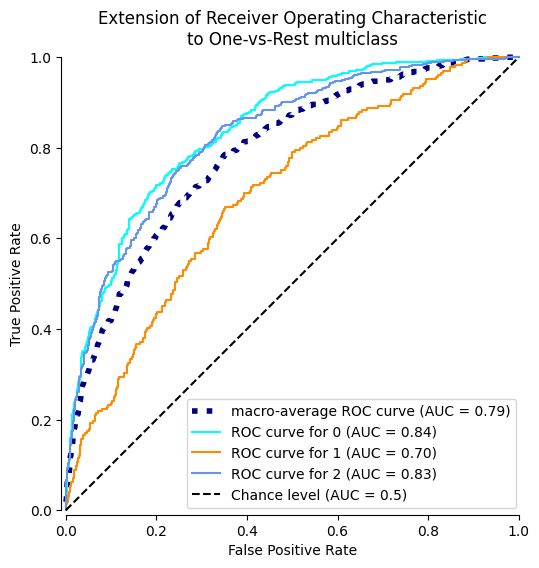

In [68]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    sk.metrics.RocCurveDisplay.from_predictions(
        y_onehot_train[:, class_id],
        proba_predictions_fs[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
        despine=True,
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

## Store Variables for later

In [69]:
pickle.dump(X_train_reduced,open(X_train_filename,"wb"))
pickle.dump(X_test_reduced,open(X_test_filename,"wb"))
pickle.dump(y_train,open(y_train_filename,"wb"))
pickle.dump(y_test,open(y_test_filename,"wb"))
pickle.dump(bin_train,open(bin_train_filename,"wb"))
pickle.dump(bin_test,open(bin_test_filename,"wb"))
pickle.dump(model_fs,open(model_filename,"wb"))

[CV 1/2] END booster=gbtree, colsample_bylevel=0.5967614139202524, colsample_bytree=1.0, eval_metric=auc, gamma=0.12915443365094642, learning_rate=0.025136022001151413, max_delta_step=5, max_depth=12, min_child_weight=1, n_estimators=279, objective=multi:softmax, reg_alpha=1.6645638296230612e-09, reg_lambda=3.843136744976635e-06, subsample=0.8900303419147679;, score=0.656 total time=   0.7s
[CV 2/2] END booster=gbtree, colsample_bylevel=0.5967614139202524, colsample_bytree=1.0, eval_metric=auc, gamma=0.12915443365094642, learning_rate=0.025136022001151413, max_delta_step=5, max_depth=12, min_child_weight=1, n_estimators=279, objective=multi:softmax, reg_alpha=1.6645638296230612e-09, reg_lambda=3.843136744976635e-06, subsample=0.8900303419147679;, score=0.674 total time=   0.9s
[CV 1/2] END booster=gbtree, colsample_bylevel=0.5073180174174445, colsample_bytree=0.9622630399665618, eval_metric=auc, gamma=4.9051344654427e-07, learning_rate=0.04120234979900533, max_delta_step=1, max_depth=1